In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import requests
import json
from urllib.request import urlopen
from IPython.display import JSON
from pandas.io.json import json_normalize

from datetime import datetime
from datetime import timedelta

import time

# Config & functions

In [5]:
df_account = None

## Function Save to excel with multiple sheet
def DF_TO_EXCEL_MUL(dfs, filename):
    writer = pd.ExcelWriter(filename, engine='xlsxwriter')
    for sheetname, df in dfs.items():  # loop through `dict` of dataframes
        df.to_excel(writer, sheet_name=sheetname)  # send df to writer
        worksheet = writer.sheets[sheetname]  # pull worksheet object
        for idx, col in enumerate(df):  # loop through all columns
            series = df[col]
            max_len = max((
                series.astype(str).map(len).max(),  # len of largest item
                len(str(series.name))  # len of column name/header
                )) + 1  # adding a little extra space
            worksheet.set_column(idx, idx, max_len)  # set column width
    writer.save()

## Load Account Name
def get_account():
    df_account = pd.read_excel('data/List of well-known Names used to identify accounts.xlsx')
    df_account.fillna('', inplace=True)
    df_account = df_account.sort_values(by='XRP', ascending=False)
    return df_account

## Find Account Description
def find_account_desc(account):
    if not dir().count('df_account'):
        df_account = get_account()
        
    try:
        _df = df_account.loc[df_account.account == account, ['name','desc']].astype(str)
        return '{}{}'.format(_df.name.values[0], '({})'.format(_df.desc.values[0]) if len(_df.desc.values[0]) > 0 else '')
    except:
        return 'Unknow'

## Get account balances
def get_balances(ACCOUNT_ADDRESS, days=90):
    now = datetime.now()  - timedelta(days=days)
    date_time = now.strftime("%Y-%m-%d")
    trans_list = []
    
    header = {
      "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
      "X-Requested-With": "XMLHttpRequest"
    }
    
    for i in range(1, days+2):

        date_time = now.strftime("%Y-%m-%d")

        url = 'https://data.ripple.com/v2/accounts/{ACCOUNT_ADDRESS}/balances?currency=XRP&date={date_time}T00:00:00Z&limit=3'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS, date_time=date_time)
        r = requests.get(url, headers=header)
        data = json.loads(r.text)

        if data['result'] != 'error':
            value = float(data['balances'][0]['value'])
            trans_list.append([ACCOUNT_ADDRESS, date_time, value])

        now = now  + timedelta(days=1)

    df_balance = pd.DataFrame(trans_list, columns=['Account', 'Date', 'Balance'])
    df_balance.set_index(['Date'], inplace=True)
    
    return df_balance

## Get transactions
def get_transactions(ACCOUNT_ADDRESS, days, limit, descending):
    start = datetime.now() - timedelta(days=days)
    date_start = start.strftime("%Y-%m-%dT%H:%M:%SZ")

    end = datetime.now()
    date_end = end.strftime("%Y-%m-%dT%H:%M:%SZ")

    url = 'https://data.ripple.com/v2/accounts/{ACCOUNT_ADDRESS}/transactions?start={date_start}&end={date_end}&type=Payment&result=tesSUCCESS&limit={limit}&descending={descending}'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS, date_start=date_start, date_end=date_end, limit=limit, descending=descending)

    header = {
      "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
      "X-Requested-With": "XMLHttpRequest"
    }

    r = requests.get(url, headers=header)
    data = json.loads(r.text)

    return data

## Convert JSON to DataFrame
def convert_to_dataframe(account, data):
    if data['result'] == "error":
        print(data['message'])
        return
    
    if data['count'] == 0:
        print('Data not found!')
        return
    
    trans_list=[]
    for d in data['transactions']:
        account_desc = ''
        d_date = d['date']
        d_hash = d['hash']
        d_tx_from = d['tx']['Account']
        d_tx_from_desc = ''
        d_tx_type = d['tx']['TransactionType']
        d_tx_flow = ''
        d_tx_to = d['tx']['Destination']
        d_tx_to_desc = ''
        d_tx_dt = d['tx']['DestinationTag'] if d['tx'].__contains__('DestinationTag') else ''
        
        d_tx_amount = 0
        d_tx_currency = ''
        d_tx_issuer = ''
        if str(type(d['tx']['Amount'])) != "<class 'dict'>":
            d_tx_amount = float(d['tx']['Amount'])  / 1000000
        else:
            d_tx_amount = float(d['tx']['Amount']['value']) / 1000000
            d_tx_currency = d['tx']['Amount']['currency'][0:8]
            d_tx_issuer = d['tx']['Amount']['issuer']
        
        d_meta_delivered_amount = 0
        if str(type(d['meta']['delivered_amount'])) != "<class 'dict'>":
            d_meta_delivered_amount =  float(d['meta']['delivered_amount'])  / 1000000
        else:
            d_meta_delivered_amount =  float(d['meta']['delivered_amount']['value'])  / 1000000
            
        d_tx_fee = float(d['tx']['Fee']) / 1000000
        d_meta_result = d['meta']['TransactionResult']

        trans_list.append([account, account_desc, d_date, d_hash, d_tx_from, d_tx_from_desc, d_tx_type, d_tx_flow, d_tx_to, d_tx_to_desc, d_tx_dt, d_tx_amount, d_tx_currency, d_tx_issuer, d_meta_delivered_amount, d_tx_fee, d_meta_result])

    df_trans = pd.DataFrame(trans_list, columns=['account','Account Desc', 'Date','Tx hash','From','From Desc','Type','Flow','To','To Desc','DT','Amount', 'Currency', 'Issuer', 'Delivered Amount', 'Fee', 'Result'])
    
    df_trans['Account Desc'] = df_trans['account'].apply(lambda x: find_account_desc(x))
    df_trans['From Desc'] = df_trans['From'].apply(lambda x: find_account_desc(x))
    df_trans['To Desc'] = df_trans['To'].apply(lambda x: find_account_desc(x))
    df_trans['Flow'] = df_trans[['account', 'To']].apply(lambda x: 'IN' if x['account'] == x['To'] else 'OUT', axis=1)
    
    return df_trans

def get_account_info(ACCOUNT_ADDRESS):
    url = 'https://api.xrpscan.com/api/v1/account//{ACCOUNT_ADDRESS}'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS)

    header = {
      "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
      "X-Requested-With": "XMLHttpRequest"
    }

    r = requests.get(url, headers=header)
    data = json.loads(r.text)

    acc_list = {'account': [data['account']], 'accountName':['{}{}'.format(data['accountName']['name'], '({})'.format(data['accountName']['desc']) if len(data['accountName']['desc'])> 0 else '') if data['accountName'] != None else 'Unknow'], 'parent': [data['parent']], 'parentName':[ data['parentName']['name'] if data['parentName'] != None else ''] , 'inception':[data['inception']] , 'initial_balance':[ data['initial_balance'] ], 'xrpBalance':[float(data['xrpBalance'])], 'Note':''}
    df_account_info = pd.DataFrame(acc_list, columns=['account','accountName','parent','parentName','inception','initial_balance','xrpBalance', 'Note'])
    
    return df_account_info

# Get account infomation

In [ ]:
import requests

ACCOUNT_ADDRESS = 'rMvYS27SYs5dXdFsUgpvv1CSrPsCz7ePF5'
url = 'https://api.xrpscan.com/api/v1/account//{ACCOUNT_ADDRESS}'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS)

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)
data = json.loads(r.text)
JSON(data, expanded=True)


In [ ]:
def get_account_info(ACCOUNT_ADDRESS):
    url = 'https://api.xrpscan.com/api/v1/account//{ACCOUNT_ADDRESS}'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS)

    header = {
      "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
      "X-Requested-With": "XMLHttpRequest"
    }

    r = requests.get(url, headers=header)
    data = json.loads(r.text)

    acc_list = {'account': [data['account']], 'parent': [data['parent']], 'parentName':[ data['parentName']['name']] , 'inception':[data['inception']] , 'initial_balance':[ data['initial_balance'] ], 'xrpBalance':[data['xrpBalance']]}
    df_account_info = pd.DataFrame(acc_list, columns=['account','parent','parentName','inception','initial_balance','xrpBalance'])
    
    return df_account_info

# Get Payment flows

In [ ]:
ACCOUNT_ADDRESS = 'rfjW34DYFGF6nZHj8zJJK3dnD7nZoeoAAU'
url = 'https://api.xrpscan.com/api/v1/account/{ACCOUNT_ADDRESS}/payment_flows'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS)

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)
data = json.loads(r.text)
#JSON(data, expanded=True)
df = json_normalize(data)
df

# Get well-known account

In [ ]:
import requests
import json
from pandas.io.json import json_normalize

url = 'https://api.xrpscan.com/api/v1/names/well-known'

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)

data = json.loads(r.text)
df = json_normalize(data)
df.fillna('', inplace=True)
df.loc[df.name.str.contains('Binance')]

In [ ]:
df.to_excel('data/List of well-known Names used to identify accounts.xlsx')

# Get Account Balances

In [ ]:
import pandas as pd
import requests
import json
from urllib.request import urlopen
from IPython.display import JSON
from pandas.io.json import json_normalize

from datetime import datetime
from datetime import timedelta

now = datetime.now() - timedelta(days=1)
date_time = now.strftime("%Y-%m-%d")

ACCOUNT_ADDRESS = 'rEahGW5VLYQH2vGBfFmbv9BBpWSTDoukGR'
url = 'https://data.ripple.com/v2/accounts/{ACCOUNT_ADDRESS}/balances?currency=XRP&date={date_time}T00:00:00Z&limit=3'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS, date_time=date_time)

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)

data = json.loads(r.text)
JSON(data, expanded=True)

# Get daily reports

In [ ]:
import pandas as pd
import requests
import json
from urllib.request import urlopen
from IPython.display import JSON
from pandas.io.json import json_normalize

from datetime import datetime
from datetime import timedelta

now = datetime.now() - timedelta(days=1)
date_time = now.strftime("%Y-%m-%d")

url = 'https://data.ripple.com/v2/reports/{date_time}T00:00:00Z?accounts=true&payments=true'.format(date_time=date_time)

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

r = requests.get(url, headers=header)

data = json.loads(r.text)
JSON(data, expanded=True)

# Get Account balances

## Today Balance

In [ ]:
import pandas as pd
import requests
import json
from urllib.request import urlopen
from IPython.display import JSON
from pandas.io.json import json_normalize

from datetime import datetime
from datetime import timedelta
import time

df_name = pd.read_excel('data/List of Monitor Accounts.xlsx')
df_name.fillna('', inplace=True)

now = datetime.now()
date_time = now.strftime("%Y-%m-%d")

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

df_xrp = df_name.copy(deep=True)

print('Begin')

df_name = df_name.sort_values(by='XRP', ascending=False)
df_name = df_name[:100] # get top 30 balance

for _, row in df_name.iterrows():
    print('{}-{}-{}'.format(row['account'], row['name'], row['desc']))

    ACCOUNT_ADDRESS = row['account']
    
    url = 'https://data.ripple.com/v2/accounts/{ACCOUNT_ADDRESS}/balances?currency=XRP&date={date_time}T00:00:00Z&limit=3'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS, date_time=date_time)

    r = requests.get(url, headers=header)

    data = json.loads(r.text)
    if data['result'] != 'error':
        df_xrp.loc[df_xrp['account'] == ACCOUNT_ADDRESS, date_time] = float(data['balances'][0]['value'])
        
    #print('-----------------------')
    time.sleep(0.001)   # Delays for 1 seconds. You can also use a float value.

df_xrp['verified'] = df_xrp['verified'].astype(bool)

df_xrp.to_excel('data/{}-List of Monitor Accounts.xlsx'.format(date_time), index=False)

print('Done.')

## Get Account Balances History

In [ ]:
import pandas as pd
import requests
import json
from urllib.request import urlopen
from IPython.display import JSON
from pandas.io.json import json_normalize

from datetime import datetime
from datetime import timedelta
import time

df_account = pd.read_excel('data/List of Monitor Accounts.xlsx')
df_account.fillna('', inplace=True)
df_account['verified'] = df_xrp['verified'].astype(bool)

now = datetime.now()  - timedelta(days=30)
date_time = now.strftime("%Y-%m-%d")

header = {
  "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
  "X-Requested-With": "XMLHttpRequest"
}

df_balance = df_account.copy(deep=True)

print('Begin')

df_account = df_account.sort_values(by='XRP BALANCES', ascending=False)
df_account = df_account[:100] # get top 100 balance

for _, row in df_account.iterrows():
    print('{}-{}-{}'.format(row['account'], row['name'], row['desc']))

    ACCOUNT_ADDRESS = row['account']
    
    url = 'https://data.ripple.com/v2/accounts/{ACCOUNT_ADDRESS}/balances?currency=XRP&date={date_time}T00:00:00Z&limit=3'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS, date_time=date_time)

    r = requests.get(url, headers=header)

    data = json.loads(r.text)
    if data['result'] != 'error':
        df_balance.loc[df_balance['account'] == ACCOUNT_ADDRESS, date_time] = float(data['balances'][0]['value'])
        
    #print('-----------------------')
    time.sleep(0.001)   # Delays for 1 seconds. You can also use a float value.



df_balance.to_excel('data/{}-List of Monitor Accounts.xlsx'.format(date_time), index=False)

print('Done.')

In [ ]:
df_account = get_account()

In [ ]:

def get_balances(ACCOUNT_ADDRESS, days=90):
    now = datetime.now()  - timedelta(days=days)
    date_time = now.strftime("%Y-%m-%d")
    trans_list = []
    
    header = {
      "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
      "X-Requested-With": "XMLHttpRequest"
    }
    
    for i in range(1, days+1):

        date_time = now.strftime("%Y-%m-%d")

        url = 'https://data.ripple.com/v2/accounts/{ACCOUNT_ADDRESS}/balances?currency=XRP&date={date_time}T00:00:00Z&limit=3'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS, date_time=date_time)
        r = requests.get(url, headers=header)
        data = json.loads(r.text)

        if data['result'] != 'error':
            value = float(data['balances'][0]['value'])
            trans_list.append([ACCOUNT_ADDRESS, date_time, value])

        now = now  + timedelta(days=1)

    df_balance = pd.DataFrame(trans_list, columns=['Account', 'Date', 'Balance'])
    df_balance.set_index(['Date'], inplace=True)
    
    return df_balance


## Get Account info

In [13]:

ACCOUNT_ADDRESS = 'rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ'

df_account_info = get_account_info(ACCOUNT_ADDRESS)
ac_list = []
for c in list(df_account_info):
    ac_list.append([c, df_account_info[c].values[0]])
    
cols = ['desc','info']
df_account_info_x = pd.DataFrame(ac_list, columns=cols)
df_account_info_x.set_index('desc', inplace=True)

account_name = df_account_info['accountName'].values[0]

print(df_account_info_x.to_csv(sep='\t'))

desc	info
account	rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ
accountName	Binance(4)
parent	rH71Wv8YCeHCbMfWDrFGCDuUBhxQB2HLN1
parentName	Binance
inception	2018-08-06T10:52:31.000Z
initial_balance	100
xrpBalance	994852746.631793
Note	



In [14]:
df_balance = get_balances(ACCOUNT_ADDRESS, 30)
df_balance['Account Desc'] = df_balance['Account'].apply(lambda x: find_account_desc(x))

df_balance

,Account,Balance,Account Desc
Date,,,
2020-04-17,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,9.539117e+08,Binance(4)
2020-04-18,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,9.539117e+08,Binance(4)
2020-04-19,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,9.539117e+08,Binance(4)
2020-04-20,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,9.539117e+08,Binance(4)
2020-04-21,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,9.539117e+08,Binance(4)
2020-04-22,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,9.539117e+08,Binance(4)
2020-04-23,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,9.539117e+08,Binance(4)
2020-04-24,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,9.539117e+08,Binance(4)
2020-04-25,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,9.539117e+08,Binance(4)


## Display in Graph

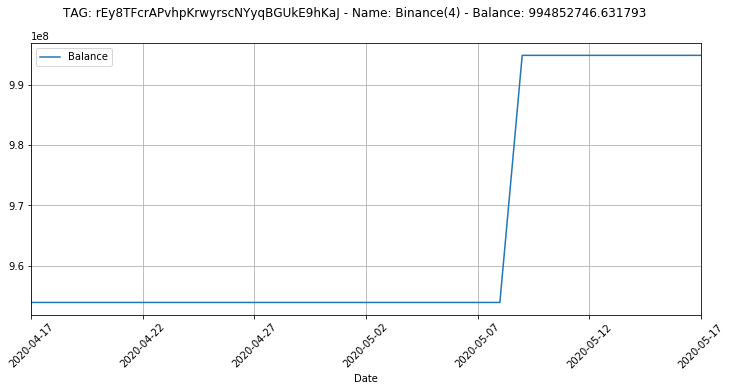

In [15]:
import matplotlib.pyplot as plt

df_balance[['Balance']].plot(grid=True, figsize=(12, 5))
plt.suptitle('TAG: {} - Name: {} - Balance: {}'.format(ACCOUNT_ADDRESS, account_name, df_balance['Balance'].tail(1).values[0]))
plt.xticks(rotation=45)
plt.show()

## Find Transactions

In [16]:
if not dir().count('df_account'):
    df_account = get_account()

print(ACCOUNT_ADDRESS)
data = get_transactions(ACCOUNT_ADDRESS, days=300, limit=400, descending=True)
df_trans = convert_to_dataframe(ACCOUNT_ADDRESS, data)
df_trans

rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ


,account,Account Desc,Date,Tx hash,From,From Desc,Type,Flow,To,To Desc,DT,Amount,Currency,Issuer,Delivered Amount,Fee,Result
0,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,Binance(4),2020-05-08T01:11:10+00:00,DAC65674C195D1F840BCC683170C40B1D96EA1DBE90E54...,rJb5KsHsDHF1YS5B5DU6QCkH5NsPaKQTcy,Binance(2),Payment,IN,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,Binance(4),,4.094105e+07,,,4.094105e+07,0.100000,tesSUCCESS
1,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,Binance(4),2020-03-11T11:10:50+00:00,B55709CC4DFC0009E13CAD438C1281DD83D3298EACF700...,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,Binance(4),Payment,OUT,rJb5KsHsDHF1YS5B5DU6QCkH5NsPaKQTcy,Binance(2),,2.500089e+07,,,2.500089e+07,0.000030,tesSUCCESS
2,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,Binance(4),2020-02-13T00:02:52+00:00,63CFDBBFDD1B9E90E5D508AD900BD5D0F2DDCA61ADCAA9...,rJb5KsHsDHF1YS5B5DU6QCkH5NsPaKQTcy,Binance(2),Payment,IN,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,Binance(4),,4.163290e+07,,,4.163290e+07,0.100000,tesSUCCESS
3,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,Binance(4),2020-01-31T18:29:00+00:00,09719E933A30094B761ECE9552CBA01BC2736D92941EAF...,rJb5KsHsDHF1YS5B5DU6QCkH5NsPaKQTcy,Binance(2),Payment,IN,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,Binance(4),,4.006156e+07,,,4.006156e+07,0.100000,tesSUCCESS
4,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,Binance(4),2020-01-19T08:20:31+00:00,2E1594AAD19785C53B64D1EEAB018ED5B3180ACD25E7D3...,rJb5KsHsDHF1YS5B5DU6QCkH5NsPaKQTcy,Binance(2),Payment,IN,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,Binance(4),,4.025069e+07,,,4.025069e+07,0.200000,tesSUCCESS
5,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,Binance(4),2019-12-20T18:26:30+00:00,A2980BA92C8486DD4322D8E12DB1AC834330E46EB2A54D...,rJb5KsHsDHF1YS5B5DU6QCkH5NsPaKQTcy,Binance(2),Payment,IN,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,Binance(4),,4.317803e+07,,,4.317803e+07,0.200000,tesSUCCESS
6,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,Binance(4),2019-11-25T23:19:50+00:00,5693401A34ECBC5F33944C9AC46CC9BE2C83FCCCAFAAF1...,rJb5KsHsDHF1YS5B5DU6QCkH5NsPaKQTcy,Binance(2),Payment,IN,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,Binance(4),,6.804016e+07,,,6.804016e+07,0.200000,tesSUCCESS
7,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,Binance(4),2019-11-25T19:35:10+00:00,44F6368C1DABD29370D1E98F9915F0EA76C74F7B599E04...,rGNAobtryQMdCtSG2HbbmKKCLkm1vk32SS,Unknow,Payment,IN,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,Binance(4),,2.000000e+00,,,2.000000e+00,0.010442,tesSUCCESS
8,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,Binance(4),2019-11-25T19:34:10+00:00,4B07E192FA64595F14D79FA9D94D094C1941908A5FB5F7...,rGNAobtryQMdCtSG2HbbmKKCLkm1vk32SS,Unknow,Payment,IN,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,Binance(4),,1.000000e+00,,,1.000000e+00,0.005000,tesSUCCESS
9,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,Binance(4),2019-11-25T11:06:40+00:00,D79D6375D0525CC5F31BD9D021370A3250F40637788B3C...,r3W6WmkeBMmMNZcLB8fVK8LEBCXz8Cijr9,Unknow,Payment,IN,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,Binance(4),,5.000000e+00,,,5.000000e+00,0.005000,tesSUCCESS


## Monitor flow IN/OUT

In [17]:
df_flow_in = df_trans.loc[df_trans.Flow == 'IN'].groupby(['From', 'From Desc','To','To Desc','DT'])['Amount'].agg(['count', "sum"])
df_flow_in.sort_values('sum', ascending=False, inplace=True)
df_flow_in

,,,,,count,sum
From,From Desc,To,To Desc,DT,,
rJb5KsHsDHF1YS5B5DU6QCkH5NsPaKQTcy,Binance(2),rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,Binance(4),,13,6.246292e+08
r3W6WmkeBMmMNZcLB8fVK8LEBCXz8Cijr9,Unknow,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,Binance(4),,1,5.000000e+00
rGNAobtryQMdCtSG2HbbmKKCLkm1vk32SS,Unknow,rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ,Binance(4),,2,3.000000e+00


In [18]:
df_flow_out = df_trans.loc[df_trans.Flow == 'OUT'].groupby(['From', 'From Desc','To','To Desc','DT'])['Amount'].agg(['count',"sum"])
df_flow_out.sort_values('sum', ascending=False, inplace=True)
df_flow_out

count  \
From                               From Desc  To                                 To Desc    DT          
rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ Binance(4) rs8ZPbYqgecRcDzQpJYAMhSxSi5htsjnza Unknow             3   
                                              rJb5KsHsDHF1YS5B5DU6QCkH5NsPaKQTcy Binance(2)         3   

                                                                                                        sum  
From                               From Desc  To                                 To Desc    DT               
rEy8TFcrAPvhpKrwyrscNYyqBGUkE9hKaJ Binance(4) rs8ZPbYqgecRcDzQpJYAMhSxSi5htsjnza Unknow         902000664.0  
                                              rJb5KsHsDHF1YS5B5DU6QCkH5NsPaKQTcy Binance(2)      77668664.0

## Export data to Excel

In [ ]:
date_time = datetime.now().strftime("%Y-%m-%d")
dfs = {'account_info': df_account_info_x, 'balance': df_balance, 'transactions': df_trans, 'flow_in': df_flow_in, 'flow_out': df_flow_out}
filename = 'data/{}-TAG_FLOW-{}-{}.xlsx'.format(date_time, account_name, ACCOUNT_ADDRESS)
DF_TO_EXCEL_MUL(dfs, filename)
print(filename)
print('Done!')

# Get Transactions

## Main function

In [ ]:
frames = []
df_name.fillna('', inplace=True)
for _, row in df_name.iterrows():
    print('{}-{}-{}'.format(row['account'], row['name'], row['desc']))
    ACCOUNT_ADDRESS = row['account']
    data = load_transactions(ACCOUNT_ADDRESS)
    
    if data.__contains__('result'):
        if data['result'] == 'success' and data['count'] > 0:
            df_tran = convert_to_dataframe(ACCOUNT_ADDRESS, data)
            frames.append(df_tran)

df_trans = pd.concat(frames)
df_trans.tail()

## Load Account Name

In [ ]:
## Load Account Name
def load_account():
    df_name = pd.read_excel('data/List of well-known Names used to identify accounts.xlsx')
    df_name.fillna('', inplace=True)
    df_name = df_name.sort_values(by='XRP', ascending=False)
    return df_name

## Load transactions

In [ ]:
## Load transactions
def load_transactions(ACCOUNT_ADDRESS):
    start = datetime.now() - timedelta(days=90)
    date_start = start.strftime("%Y-%m-%dT%H:%M:%SZ")

    end = datetime.now()
    date_end = end.strftime("%Y-%m-%dT%H:%M:%SZ")

    url = 'https://data.ripple.com/v2/accounts/{ACCOUNT_ADDRESS}/transactions?start={date_start}&end={date_end}&type=Payment&result=tesSUCCESS&limit=1000&descending=True'.format(ACCOUNT_ADDRESS=ACCOUNT_ADDRESS, date_start=date_start, date_end=date_end)

    header = {
      "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
      "X-Requested-With": "XMLHttpRequest"
    }

    r = requests.get(url, headers=header)
    data = json.loads(r.text)

    return data

## Convert JSON to DataFrame

In [ ]:
## Convert JSON to DataFrame
def convert_to_dataframe(account, data):
    if data['result'] == "error":
        print(data['message'])
        return
    
    trans_list=[]
    for d in data['transactions']:
        account_desc = ''
        d_date = d['date']
        d_hash = d['hash']
        d_tx_from = d['tx']['Account']
        d_tx_from_desc = ''
        d_tx_type = d['tx']['TransactionType']
        d_tx_flow = ''
        d_tx_to = d['tx']['Destination']
        d_tx_to_desc = ''
        d_tx_dt = d['tx']['DestinationTag'] if d['tx'].__contains__('DestinationTag') else ''
        
        d_tx_amount = 0
        d_tx_currency = ''
        d_tx_issuer = ''
        if str(type(d['tx']['Amount'])) != "<class 'dict'>":
            d_tx_amount = float(d['tx']['Amount'])  / 1000000
        else:
            d_tx_amount = float(d['tx']['Amount']['value']) / 1000000
            d_tx_currency = d['tx']['Amount']['currency'][0:8]
            d_tx_issuer = d['tx']['Amount']['issuer']
        
        d_meta_delivered_amount = 0
        if str(type(d['meta']['delivered_amount'])) != "<class 'dict'>":
            d_meta_delivered_amount =  float(d['meta']['delivered_amount'])  / 1000000
        else:
            d_meta_delivered_amount =  float(d['meta']['delivered_amount']['value'])  / 1000000
            
        d_tx_fee = float(d['tx']['Fee']) / 1000000
        d_meta_result = d['meta']['TransactionResult']

        trans_list.append([account, account_desc, d_date, d_hash, d_tx_from, d_tx_from_desc, d_tx_type, d_tx_flow, d_tx_to, d_tx_to_desc, d_tx_dt, d_tx_amount, d_tx_currency, d_tx_issuer, d_meta_delivered_amount, d_tx_fee, d_meta_result])

    df_trans = pd.DataFrame(trans_list, columns=['account','Account Desc', 'Date','Tx hash','From','From Desc','Type','Flow','To','To Desc','DT','Amount', 'Currency', 'Issuer', 'Delivered Amount', 'Fee', 'Result'])
    
    df_trans['Account Desc'] = df_trans['account'].apply(lambda x: find_desc(x))
    df_trans['From Desc'] = df_trans['From'].apply(lambda x: find_desc(x))
    df_trans['To Desc'] = df_trans['To'].apply(lambda x: find_desc(x))
    df_trans['Flow'] = df_trans[['account', 'To']].apply(lambda x: 'IN' if x['account'] == x['To'] else 'OUT', axis=1)
    
    return df_trans


## Find Account Description

In [ ]:
def find_desc(account):
    try:
        _df = df_name.loc[df_name.account == account, ['name','desc']].astype(str)
        return '{}{}'.format(_df.name.values[0], '({})'.format(_df.desc.values[0]) if len(_df.desc.values[0]) > 0 else '')
    except:
        return 'Unknow'
    